In [125]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
%run kit.ipynb as kit
%matplotlib inline 
import matplotlib.pyplot as plt
from fredapi import Fred
from IPython.display import display




In [126]:
fred = Fred(api_key="6b70d4491668e6f2fb1ac220b49b2612")

spx = fred.get_series('SP500')
bond = fred.get_series('BAMLCC4A0710YTRIV')
#gold = fred.get_series('IR14270')  # Gold price in USD/oz

# aligning
data = pd.concat([spx, bond], axis=1)
data.columns = ['SP500', 'Bond']
data = data.dropna()

returns = data.resample('ME').last().pct_change().dropna()
returns.head()

,SP500,Bond
2015-11-30,0.000505,-0.002131
2015-12-31,-0.017530,-0.009356
2016-01-31,-0.050735,0.005951
2016-02-29,-0.004128,0.011446
2016-03-31,0.065991,0.025282


In [127]:
# converting to dataframes w correct shape
risky = returns[['SP500']]  # monthly SP500 returns
safe = returns[['Bond']].rename(columns={'Bond':'SP500'})  # rename for CPPI

cppi_results = run_cppi(risky, safe, floor=0.8, m=3)

rets = cppi_results['Wealth'].pct_change().dropna()
summary_stats(rets)


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.12406,0.149719,-0.4792,3.717672,0.06512,0.09438,0.611309,-0.247695


<Axes: >

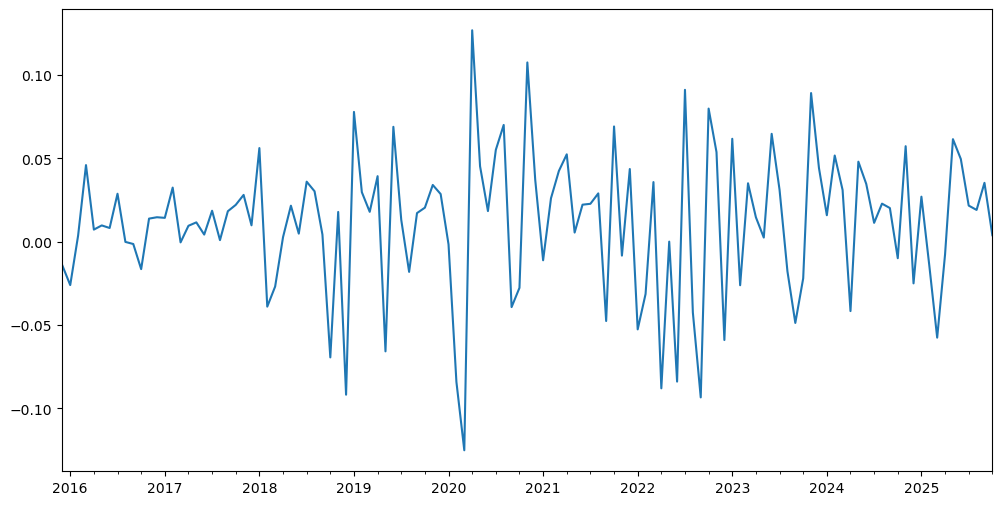

In [128]:
rets.plot(figsize = (12,6), legend = False)

In [138]:
def manual_alloc_plot(w_risky=0.8):
    """
    Plot portfolio wealth evolution and histogram for a manual allocation.
    w_risky: fraction of capital in SP500
    """
    w_safe = 1 - w_risky

    # Portfolio returns
    port_ret = w_risky * returns['SP500'] + w_safe * returns['Bond']

    # Wealth evolution
    start = 1
    wealth = (1 + port_ret).cumprod() * start

    # Plot wealth and distribution
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), gridspec_kw={'width_ratios':[3,2]})

    wealth.plot(ax=ax1, color='green', lw=2)
    ax1.axhline(y=start, color='black', ls=':')
    ax1.set_title(f"Portfolio Wealth (SP500 {w_risky*100:.0f}%, Bonds {w_safe*100:.0f}%)")

    ax2.hist(port_ret, bins=30, color='green', ec='white', orientation='horizontal')
    ax2.axhline(y=0, color='black', ls=':')
    ax2.set_title("Monthly Return Distribution")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Portfolio Wealth")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Wealth")

    plt.show()

    # Compute summary stats
    mean_annual_ret = (1 + port_ret.mean())**12 - 1
    annual_vol = port_ret.std() * np.sqrt(12)
    sharpe = mean_annual_ret / annual_vol
    max_drawdown = ((wealth / wealth.cummax()) - 1).min()

    print(f"Annualized Return: {mean_annual_ret:.2%}")
    print(f"Annualized Volatility: {annual_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    
    
widgets.interact(manual_alloc_plot,
                w_risky=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.8,
                                           description="SP500 Allocation"))


interactive(children=(FloatSlider(value=0.8, description='SP500 Allocation', max=1.0, step=0.05), Output()), _…

<function __main__.manual_alloc_plot(w_risky=0.8)>